# Plots for forecasting
Forecasting + mobility data.

In [1]:
import pickle

from os.path import join, pardir

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Data

In [2]:
ROOT = pardir
OUT = join(ROOT, "data", "processed")
FIGS = join(ROOT, "reports", "figures")
MODELS = join(ROOT, "models")
#plot style
plt.style.use('ggplot')

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [3]:
data = pd.read_csv(join(OUT, "data_five_mob_cov_daily.csv"), parse_dates=['Date'])

In [4]:
data_dk=data[data['Country'] == "Denmark"]

In [5]:
data

,Date,Country,Confirmed,daily_confirmed_case,ret_rec_ch,gr_ph_ch,par_cha,tra_sta_ch,wor_ch,res_ch
0,2020-02-27,Denmark,1,0,2,1.0,21,2,3,0
1,2020-02-28,Denmark,1,2,17,1.0,23,6,2,-1
2,2020-02-29,Denmark,3,1,10,-4.0,-17,5,0,0
3,2020-03-01,Denmark,4,0,21,-7.0,-5,5,1,0
4,2020-03-02,Denmark,4,2,11,-5.0,28,1,2,0
...,...,...,...,...,...,...,...,...,...,...
457,2020-05-17,Germany,176369,182,-36,16.0,92,-25,-1,3
458,2020-05-18,Germany,176551,1227,-15,-3.0,55,-30,-26,8
459,2020-05-19,Germany,177778,695,-17,2.0,63,-30,-25,9
460,2020-05-20,Germany,178473,548,-6,34.0,84,-25,-26,6


In [6]:
PALETTE = (  # scheme: http://geog.uoregon.edu/datagraphics/color/Cat_12.txt
    "#e51932",
    "#19b2ff",
    "#ff7f00",
    "#654cff",
    "#32ff00",
    "#ffff32",
    "#ff99bf",
    "#ccbfff",
    "#a5edff",
    "#b2ff8c",
    "#ffff99",
    "#ffbf7f",
)

In [7]:
def split_forecast_cumulative(df, n_train=65):
    """Split dataframe `df` as training, test and input mobility data."""
    # just take the first 4 mobility features
    X = df.iloc[:, 3:7].values.astype(np.float_)
    # confirmed cases
    y = df.iloc[:,2].values.astype(np.float_)

    idx_train = [*range(0,n_train)]
    idx_test = [*range(n_train, len(y))]

    y_train = y[:n_train]
    y_test = y[n_train:]

    return X, y_train, y_test


def split_forecast_daily(df, n_train=65):
    """Split dataframe `df` as training, test and input mobility data."""
    # just take the first 4 mobility features
    X = df.iloc[:, 4:8].values.astype(np.float_)
    # confirmed cases
    y = df.iloc[:,3].values.astype(np.float_)

    idx_train = [*range(0,n_train)]
    idx_test = [*range(n_train, len(y))]

    y_train = y[:n_train]
    y_test = y[n_train:]

    return X, y_train, y_test

In [8]:
X, y_train, y_test = split_forecast_cumulative(data_dk)

In [9]:
with open(join(ROOT, "models", "hmc_1.pickle"), "rb") as f:
    hmc_samples = pickle.load(f)

## Plot

In [10]:
def predict(hmc_samples):
    y_hat = hmc_samples["y_pred"].mean(axis=0)
    y_std = hmc_samples["y_pred"].std(axis=0)
    y_pred_025 = y_hat - 1.96 * y_std
    y_pred_975 = y_hat + 1.96 * y_std
    return y_hat, y_pred_025, y_pred_975


def plot_forecast_mob(hmc_samples, y_train, y_test, mobility):
    """Plot the results of forecasting (dimension are different).
    
    left y-axis: forecasting
    right y-axis: mobility data
    x-axis: time
    
    Plots with two axes are very compact for manuscripts but be aware
    of the readibility in presentations.
    """
    y_hat, y_pred_025, y_pred_975 = predict(hmc_samples)
    n_train = len(y_train)
    n_test = len(y_test)
    tot = n_test + n_train
    idx_train = range(n_train)
    idx_test = range(n_train, tot)

    fig, ax1 = plt.subplots()
    # right y-axis: mobility data
    ax2 = ax1.twinx()
    # The colors of lines on different axes must not overlap.
    ax2.set_prop_cycle("color", PALETTE[2:])
    # mobility data
    for mob in mobility:
        ax2.plot(range(tot), mobility[mob], marker="o", linestyle=":", label=mob)
    # left y-axis: forecasting
    ax1.plot(idx_train, y_train, color=PALETTE[1], linestyle="-", label="true (train)")
    ax1.plot(idx_test, y_test, color=PALETTE[1], marker="x", linestyle="", label="true (test)")
    ax1.plot(idx_test[:-1], y_hat, color=PALETTE[0], linestyle="-", label="forecast")
    ax1.plot(idx_test[:-1], y_pred_025, color=PALETTE[0], linestyle="--", label="forecast + stddev")
    ax1.plot(idx_test[:-1], y_pred_975, color=PALETTE[0], linestyle="--", label="forecast - stddev")
    ax1.fill_between(idx_test[:-1], y_pred_025, y_pred_975, alpha=0.3, color=PALETTE[0])
    #ax1.set_facecolor("#202224")
    ax1.set_xlabel("Time (days)")
    ax1.set_ylabel("Confirmed COVID-19 cases")
    ax2.set_ylabel("Mobility")
    # Set the legend outside the plot area.
    fig.legend(loc="upper center")
    #frame = fig.legend(loc="upper left").get_frame()
    #frame.set_facecolor('#252325')
    plt.tight_layout()

    
def plot_forecast(hmc_samples, y_train, y_test, path=None):
    """Plot the results of forecasting (dimension are different)."""
    y_hat, y_pred_025, y_pred_975 = predict(hmc_samples)
    idx_train = range(len(y_train))
    idx_test = range(len(y_train), len(y_test) + len(y_train))

    fig, ax1 = plt.subplots()
    ax1.plot(idx_train, y_train, color=PALETTE[1], linestyle="-", label="true (train)")
    ax1.plot(idx_test, y_test, color=PALETTE[1], marker="x", linestyle="", label="true (test)")
    ax1.plot(idx_test[:-1], y_hat, color=PALETTE[0], linestyle="-", label="forecast")
    ax1.plot(idx_test[:-1], y_pred_025, color=PALETTE[0], linestyle="--", label="forecast + stddev")
    ax1.plot(idx_test[:-1], y_pred_975, color=PALETTE[0], linestyle="--", label="forecast - stddev")
    ax1.fill_between(idx_test[:-1], y_pred_025, y_pred_975, color=PALETTE[0], alpha=0.3)
    plt.tight_layout()
    if path:
        plt.savefig(path)

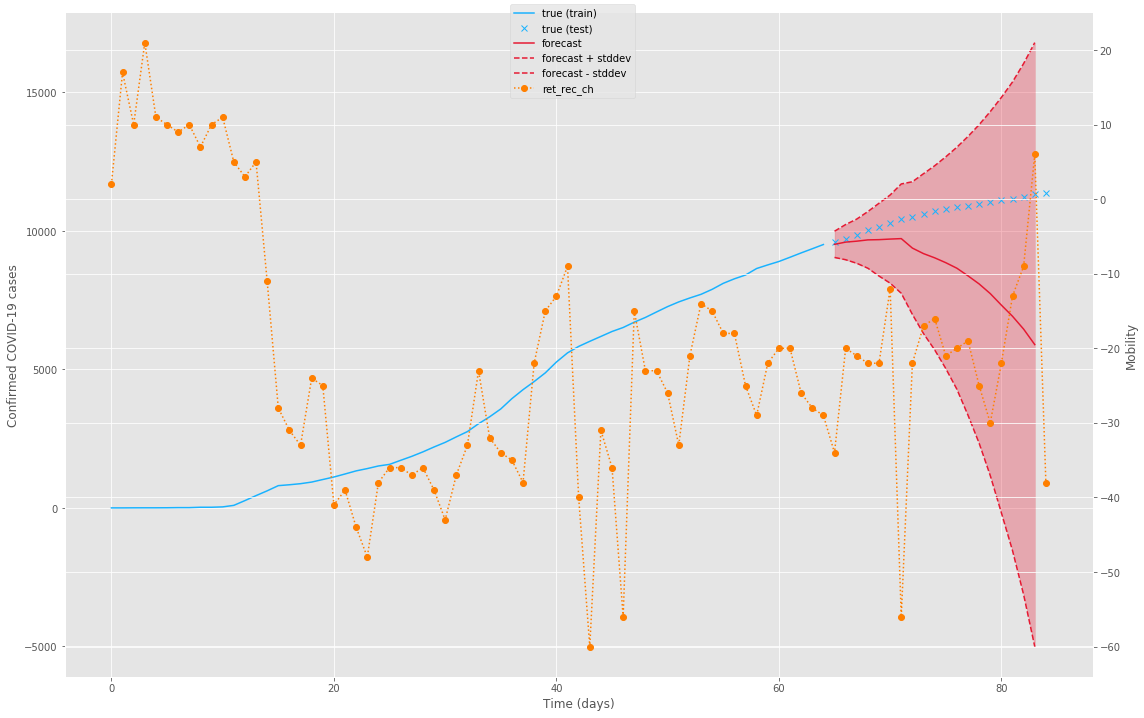

In [11]:
plot_forecast_mob(hmc_samples, y_train, y_test, mobility=data_dk.iloc[:, 4:5])
plt.savefig(join(FIGS, "forecast_mob.pdf"))

## Daily data

### Denmark

In [12]:
X, y_train, y_test = split_forecast_daily(data_dk)

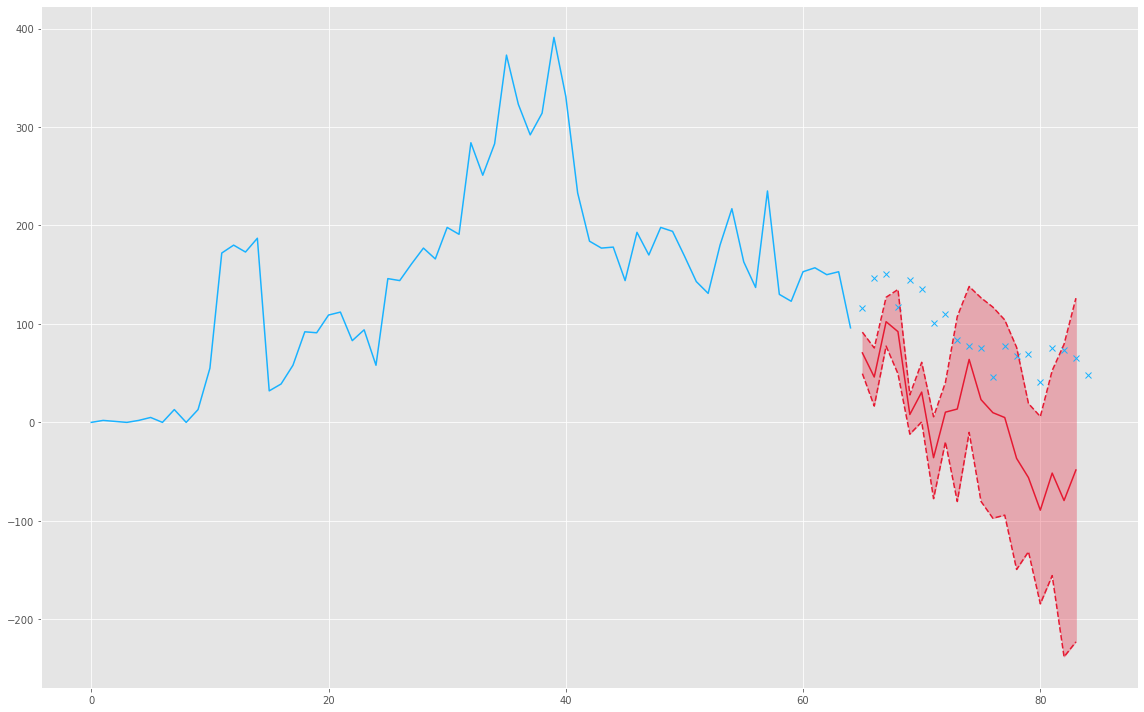

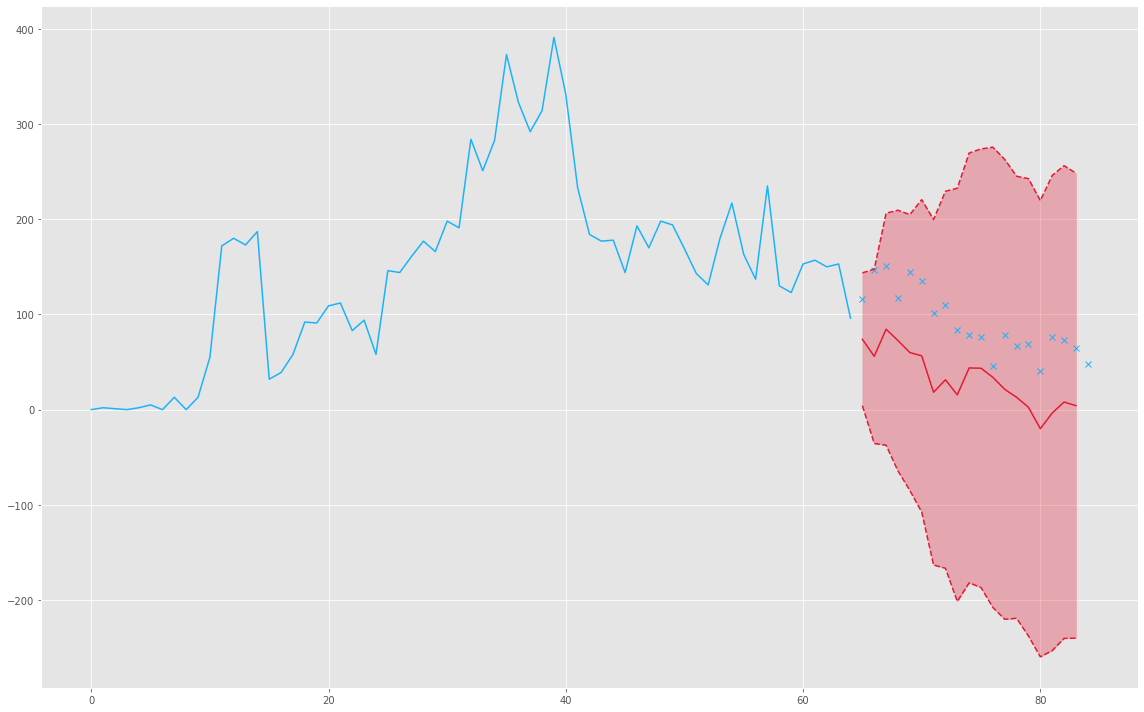

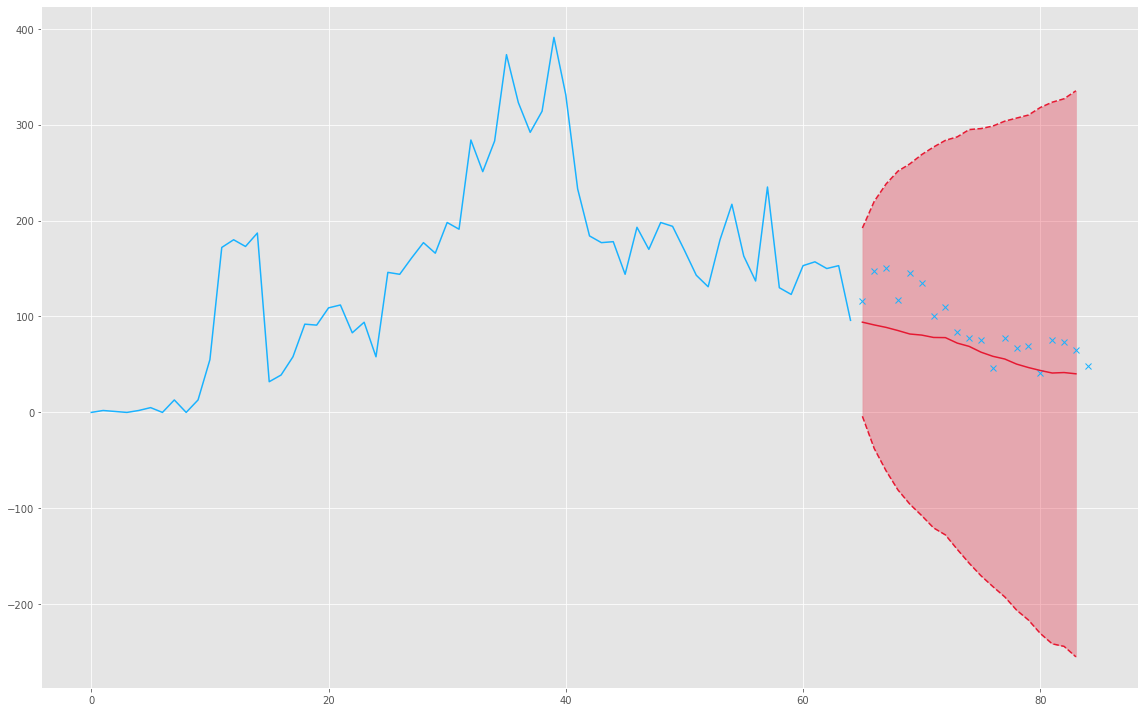

In [13]:
for i, mod in enumerate(["fixed", "non_fixed", "wo_input"]):
    with open(join(MODELS, f"hmc_cummul_{i}.pickle"), "rb") as f:
        hmc_samples = pickle.load(f)
        plot_forecast(hmc_samples, y_train, y_test, path=join(FIGS,f"{mod}_DK.pdf"))

### Finland

In [14]:
data_fi=data[data['Country'] == "Finland"]

In [15]:
X, y_train, y_test = split_forecast_daily(data_fi, 75)

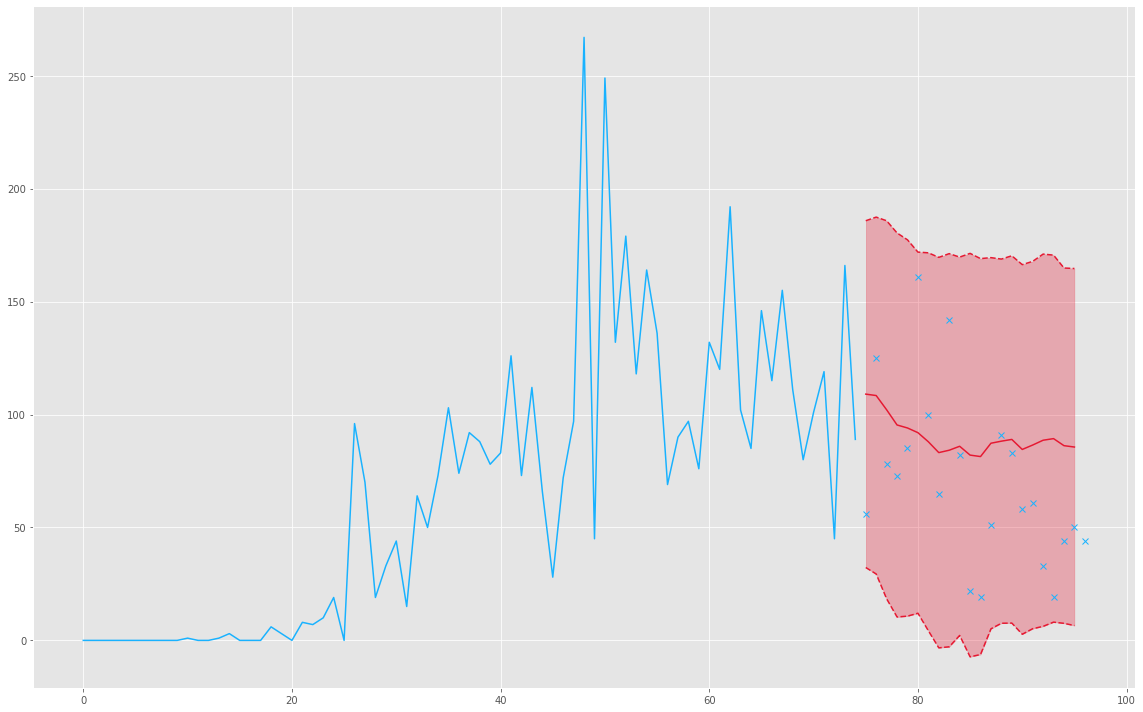

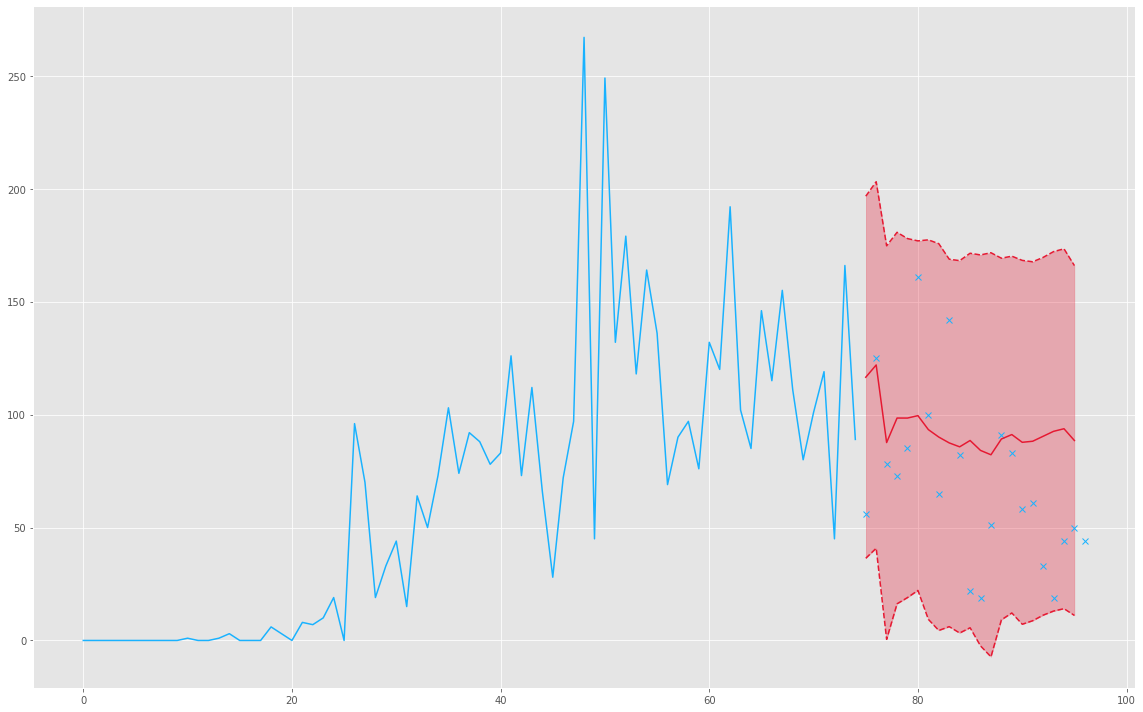

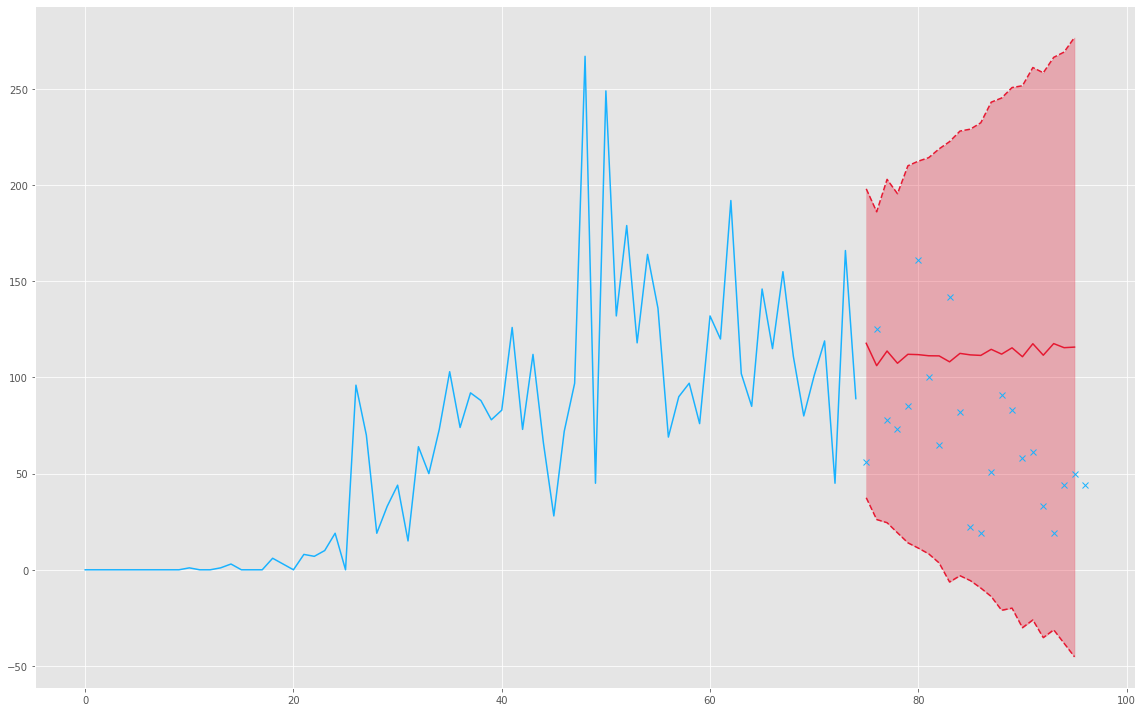

In [16]:
for i, mod in enumerate(["fixed", "non_fixed", "wo_input"]):
    with open(join(MODELS, f"hmc_cummul_{i+3}.pickle"), "rb") as f:
        hmc_samples = pickle.load(f)
        plot_forecast(hmc_samples, y_train, y_test, path=join(FIGS, f"{mod}_FI.pdf"))

### Sweden

In [17]:
data_sw=data[data['Country'] == "Sweden"]

In [18]:
X, y_train, y_test = split_forecast_daily(data_sw, 75)

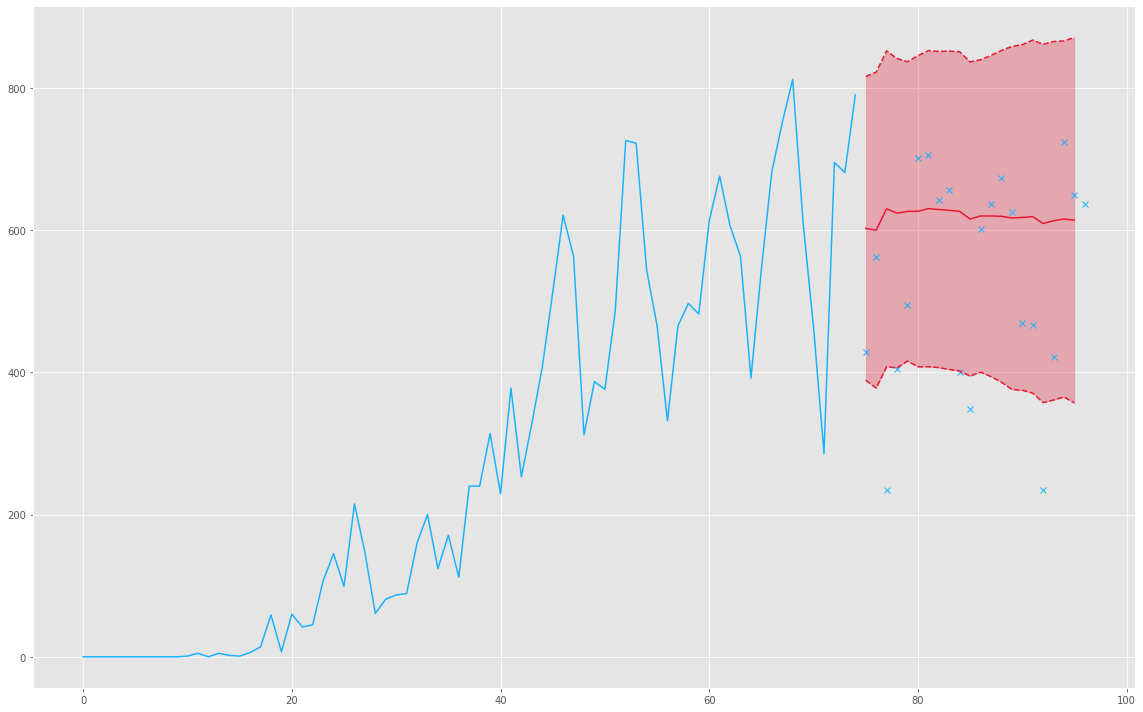

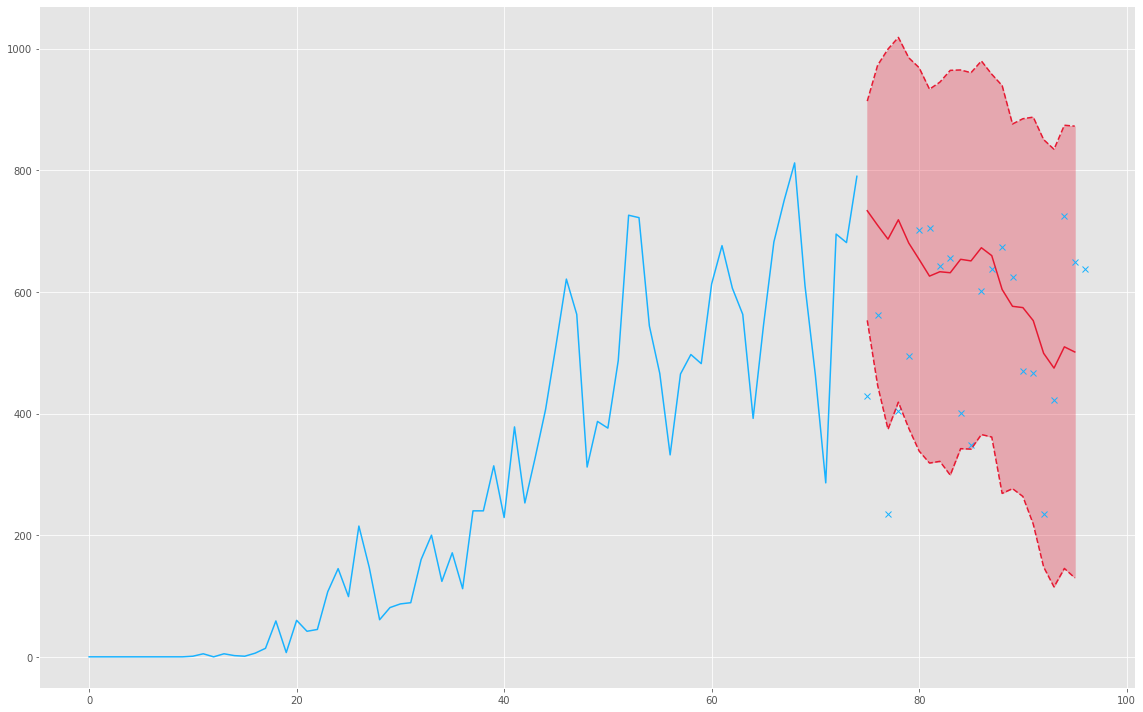

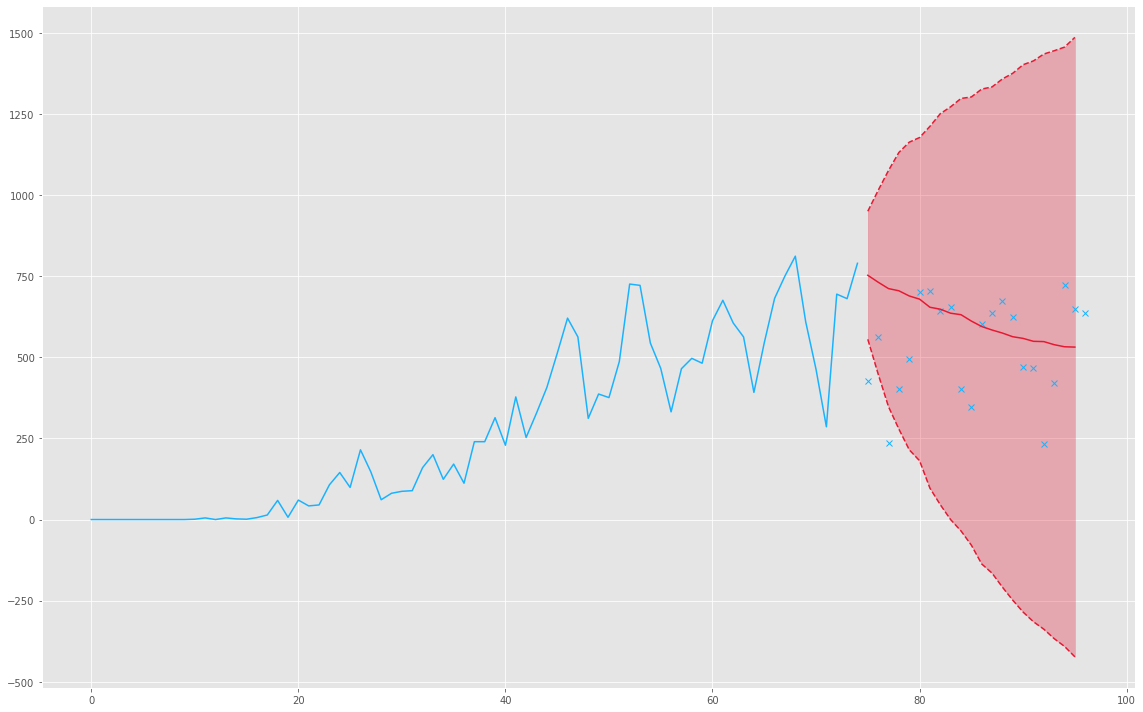

In [19]:
for i, mod in enumerate(["fixed", "non_fixed", "wo_input"]):
    with open(join(MODELS, f"hmc_cummul_{i+6}.pickle"), "rb") as f:
        hmc_samples = pickle.load(f)
        plot_forecast(hmc_samples, y_train, y_test, path=join(FIGS,f"{mod}_SW.pdf"))

## Cumulative data

In [20]:
X, y_train, y_test = split_forecast_cumulative(data_dk)

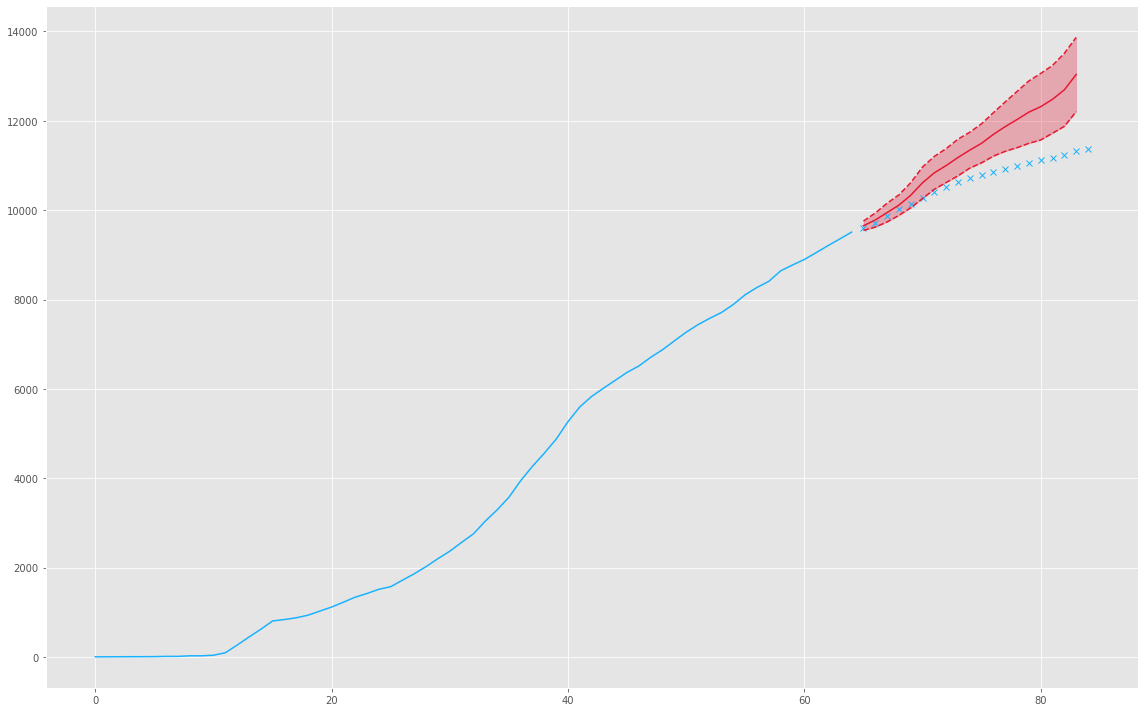

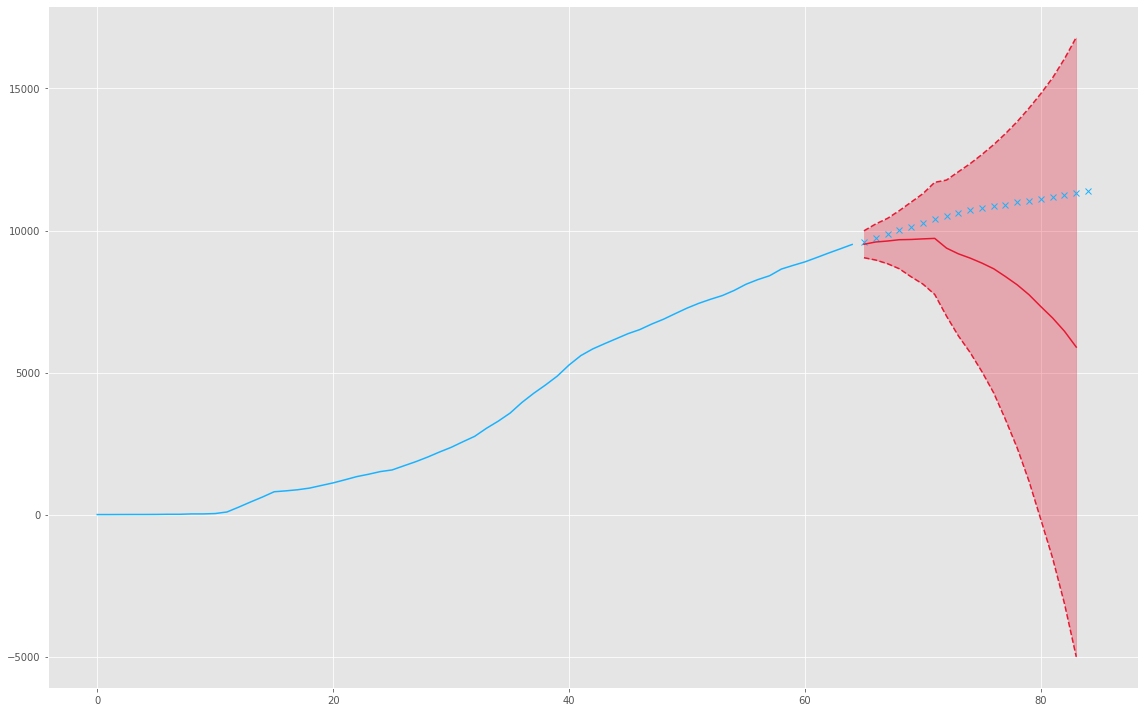

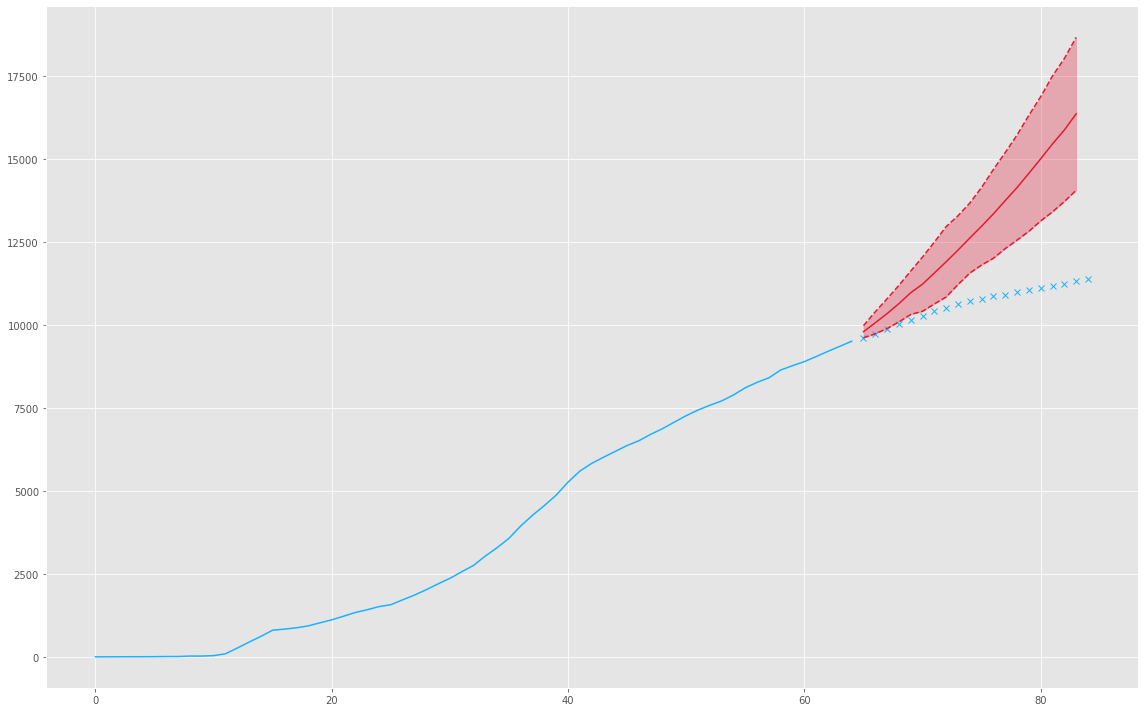

In [21]:
for i, mod in enumerate(["fixed", "non_fixed", "wo_input"]):
    with open(join(MODELS, f"hmc_{i}.pickle"), "rb") as f:
        hmc_samples = pickle.load(f)
        plot_forecast(hmc_samples, y_train, y_test, path=join(FIGS,f"{mod}_cummulative_DK.pdf"))

### Finland

In [24]:
X, y_train, y_test = split_forecast_cumulative(data_fi, 75)

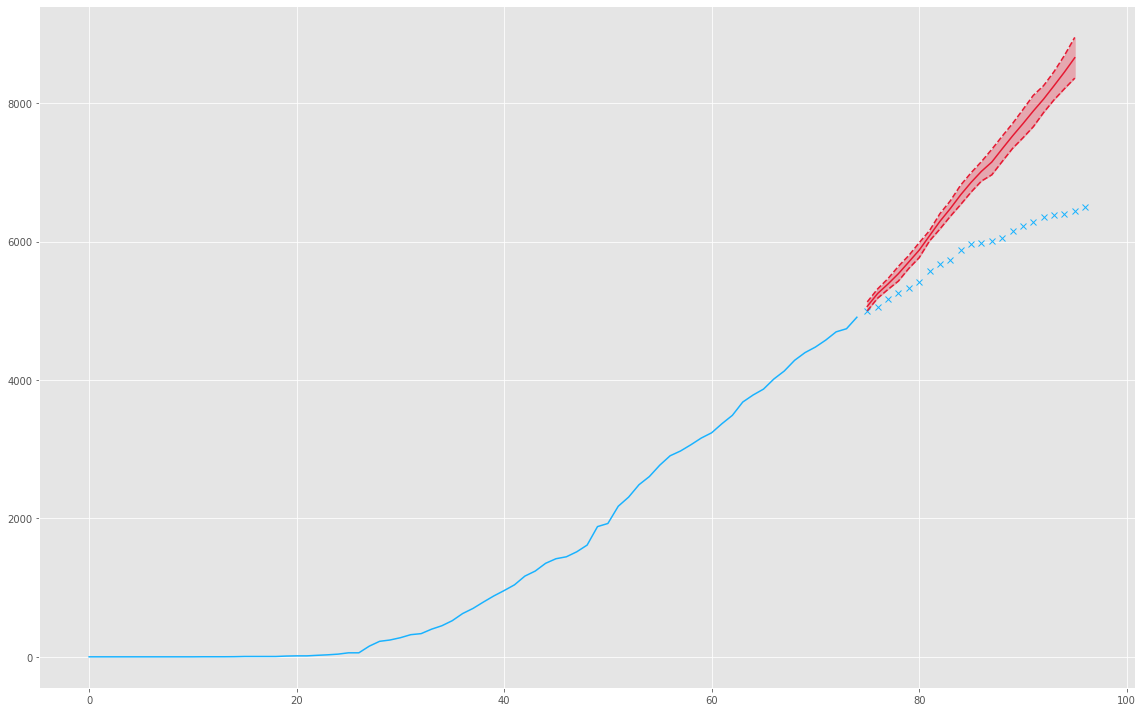

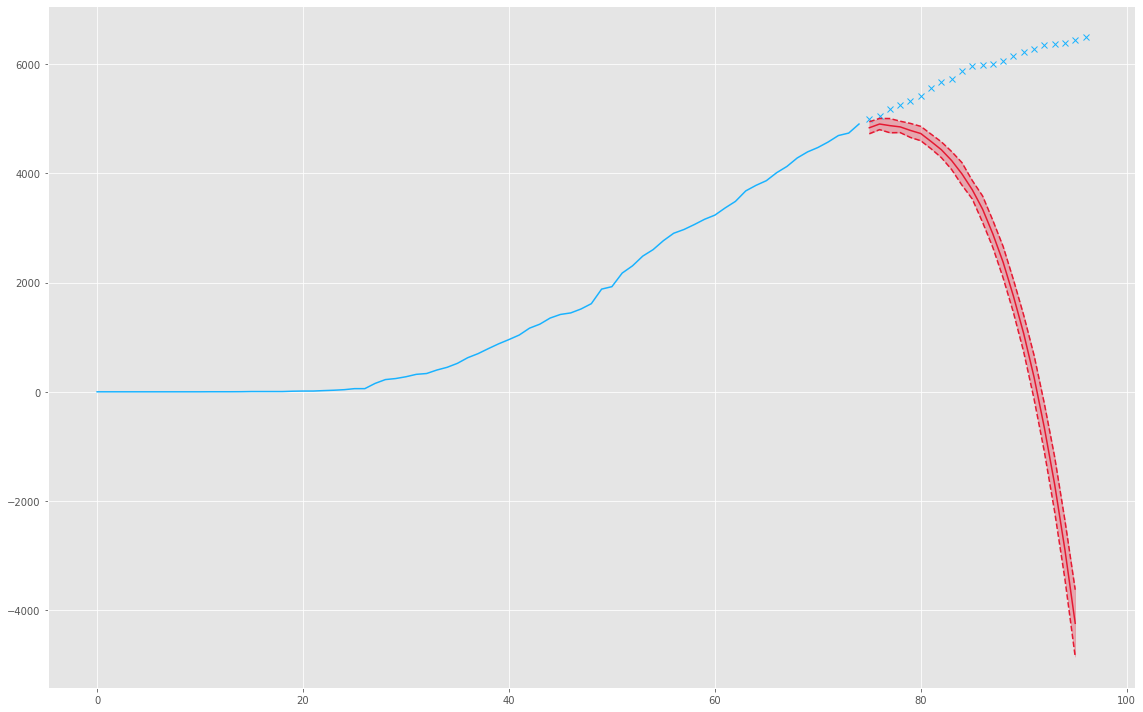

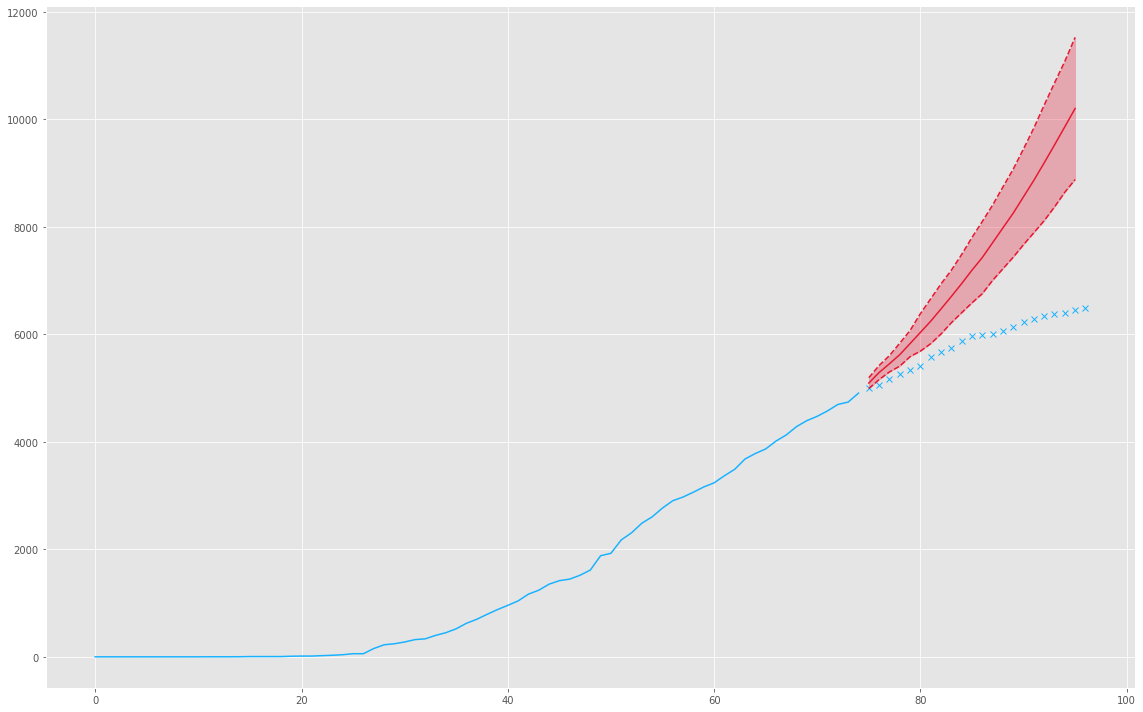

In [27]:
for i, mod in enumerate(["fixed", "non_fixed", "wo_input"]):
    with open(join(MODELS, f"hmc_fi_{i}.pickle"), "rb") as f:
        hmc_samples = pickle.load(f)
        plot_forecast(hmc_samples, y_train, y_test, path=join(FIGS,f"{mod}_cummulative_FI.pdf"))

### Sweden

In [ ]:
X, y_train, y_test = split_forecast_cumulative(data_sw, 75)

In [ ]:
for i, mod in enumerate(["fixed", "non_fixed", "wo_input"]):
    with open(join(MODELS, f"hmc_ok_{i+1}.pickle"), "rb") as f:
        hmc_samples = pickle.load(f)
        plot_forecast(hmc_samples, y_train, y_test)
        plt.show()
        plot_forecast(hmc_samples, y_train, y_test, path=join(FIGS,f"{mod}_cummulative_SW.pdf"))
        plt.savefig(join(FIGS, f"{mod}_cummulative_SW.pdf"))